In [703]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [704]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import TheilSenRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

%matplotlib inline
plt.rcParams['figure.dpi'] = 250

In [705]:
df = pd.read_csv('data/voting_data_anonymized.tsv', sep='\t')
original_columns = list(df.columns)
df.head()



,age,sex,party,party guess,race,ethnicity,precinct,prop value,voted 2010,voted 2011,voted 2012,voted 2013,voted 2014,voted 2015,voted 2016,voted 2017,voted 2018,voted 2019,voted 2020,voted 2021
0,83,M,U,R,WHITE,JEWISH,3,610.0,True,False,False,False,False,False,False,False,False,True,False,False
1,37,M,U,U,UNKNOWN,BRITISH,5,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48,F,U,D,ASIAN,EASTASIAN,3,640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,True
3,61,F,U,R,WHITE,JEWISH,2,840.0,False,False,False,True,True,True,True,True,True,True,True,False
4,40,F,U,R,WHITE,BRITISH,3,700.0,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False


In [706]:
# fill missing property values with mean property value
df['prop value'].fillna(int(df['prop value'].mean()), inplace=True)

In [707]:
# df.drop(df.loc[df['race']=='UNKNOWN'].index, inplace=True)
# df.drop(df.loc[df['sex']=='U'].index, inplace=True)

In [708]:
# drop all voters who were not registered in 2021
df.dropna(subset=['voted 2021'], axis=0, inplace=True)

In [709]:
def convert_voted_column_to_int(df, column_name):
    '''
    INPUT:
    OUTPUT:

    description
    '''
    df[column_name] = df[column_name] * 1
    df[column_name].fillna(0, inplace=True)
    return df

for i in range(2010, 2022):
    column_name = f'voted {i}'
    print(f'converting column to int: {column_name}')
    convert_voted_column_to_int(df, column_name)


converting column to int: voted 2010
converting column to int: voted 2011
converting column to int: voted 2012
converting column to int: voted 2013
converting column to int: voted 2014
converting column to int: voted 2015
converting column to int: voted 2016
converting column to int: voted 2017
converting column to int: voted 2018
converting column to int: voted 2019
converting column to int: voted 2020
converting column to int: voted 2021


In [710]:
# create dummy columns for category columns, save original columns
category_columns = list(df.select_dtypes(include=['object']).columns)
df_category_columns = pd.DataFrame()
print(category_columns)
for i in category_columns:
    print(f'creating dummies for category column: {i}')
    # df_category_columns = pd.concat([df_category_columns, df[i]])
    df_category_columns[i] = df[i]
    df = pd.concat([df.drop(i, axis=1), 
                   pd.get_dummies(df[i], prefix=i, prefix_sep='_')], 
                   axis=1)

    

['sex', 'party', 'party guess', 'race', 'ethnicity']
creating dummies for category column: sex
creating dummies for category column: party
creating dummies for category column: party guess
creating dummies for category column: race
creating dummies for category column: ethnicity


In [711]:
import itertools

stuff = [2016, 2017, 2018, 2019]

L=3

for subset in itertools.combinations(stuff, L):
    column_name = f'voted {",".join([str(x) for x in subset])}'
    df[column_name] = 1
    print(f'adding: {column_name}')
    for i in subset:
        df[column_name] = df[column_name] & df[f'voted {i}']
    df=df.copy()

df.head()

adding: voted 2016,2017,2018
adding: voted 2016,2017,2019
adding: voted 2016,2018,2019
adding: voted 2017,2018,2019


,age,precinct,prop value,voted 2010,voted 2011,voted 2012,voted 2013,voted 2014,voted 2015,voted 2016,...,ethnicity_INDIANSUBCONTINENT,ethnicity_ITALIAN,ethnicity_JAPANESE,ethnicity_JEWISH,ethnicity_MUSLIM,ethnicity_NORDIC,"voted 2016,2017,2018","voted 2016,2017,2019","voted 2016,2018,2019","voted 2017,2018,2019"
0,83,3,610.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,48,3,640.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61,2,840.0,0,0,0,1,1,1,1,...,0,0,0,1,0,0,1,1,1,1
4,40,3,700.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,56,5,1210.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [712]:
df.columns

Index(['age', 'precinct', 'prop value', 'voted 2010', 'voted 2011',
       'voted 2012', 'voted 2013', 'voted 2014', 'voted 2015', 'voted 2016',
       'voted 2017', 'voted 2018', 'voted 2019', 'voted 2020', 'voted 2021',
       'sex_F', 'sex_M', 'sex_U', 'party_D', 'party_R', 'party_U',
       'party guess_D', 'party guess_R', 'party guess_U', 'race_ASIAN',
       'race_BLACK', 'race_HISPANIC', 'race_UNKNOWN', 'race_WHITE',
       'ethnicity_AFRICANS', 'ethnicity_BRITISH', 'ethnicity_EASTASIAN',
       'ethnicity_EASTEUROPEAN', 'ethnicity_FRENCH', 'ethnicity_GERMANIC',
       'ethnicity_HISPANIC', 'ethnicity_INDIANSUBCONTINENT',
       'ethnicity_ITALIAN', 'ethnicity_JAPANESE', 'ethnicity_JEWISH',
       'ethnicity_MUSLIM', 'ethnicity_NORDIC', 'voted 2016,2017,2018',
       'voted 2016,2017,2019', 'voted 2016,2018,2019', 'voted 2017,2018,2019'],
      dtype='object')

In [713]:
print('data shape:', df.shape)

# we'll use the 2020 voting data to fit our model
X = df
y=df['voted 2020']

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

# make a copy of the train and test sets before dropping columns
df_train = X_train.copy()
df_all = X_test.copy()

# drop the 2020 and 2021 columns from the data set
drop_columns = ['voted 2020', 'voted 2021']
X_train.drop(columns=drop_columns, inplace=True)
X_test.drop(columns=drop_columns, inplace=True)

print('X shape:', X_train.shape)

# use the Theil-Sen estimator to fit a linear model
# https://en.wikipedia.org/wiki/Theil%E2%80%93Sen_estimator
lm_model = TheilSenRegressor(random_state=42, max_iter=500, fit_intercept=True, verbose=True, max_subpopulation=2000)
lm_pipeline = make_pipeline(MinMaxScaler(), PolynomialFeatures(1), lm_model)
lm_pipeline.fit(X_train, y_train)

# predict
y_test_preds = lm_pipeline.predict(X_test)
y_train_preds = lm_pipeline.predict(X_train)

# score
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print(train_score, test_score)

data shape: (11278, 46)
X shape: (8458, 44)
Breakdown point: 0.01487588735312051
Number of samples: 8458
Tolerable outliers: 125
Number of subpopulations: 2000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.28228951899699517 0.2735603520761444


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


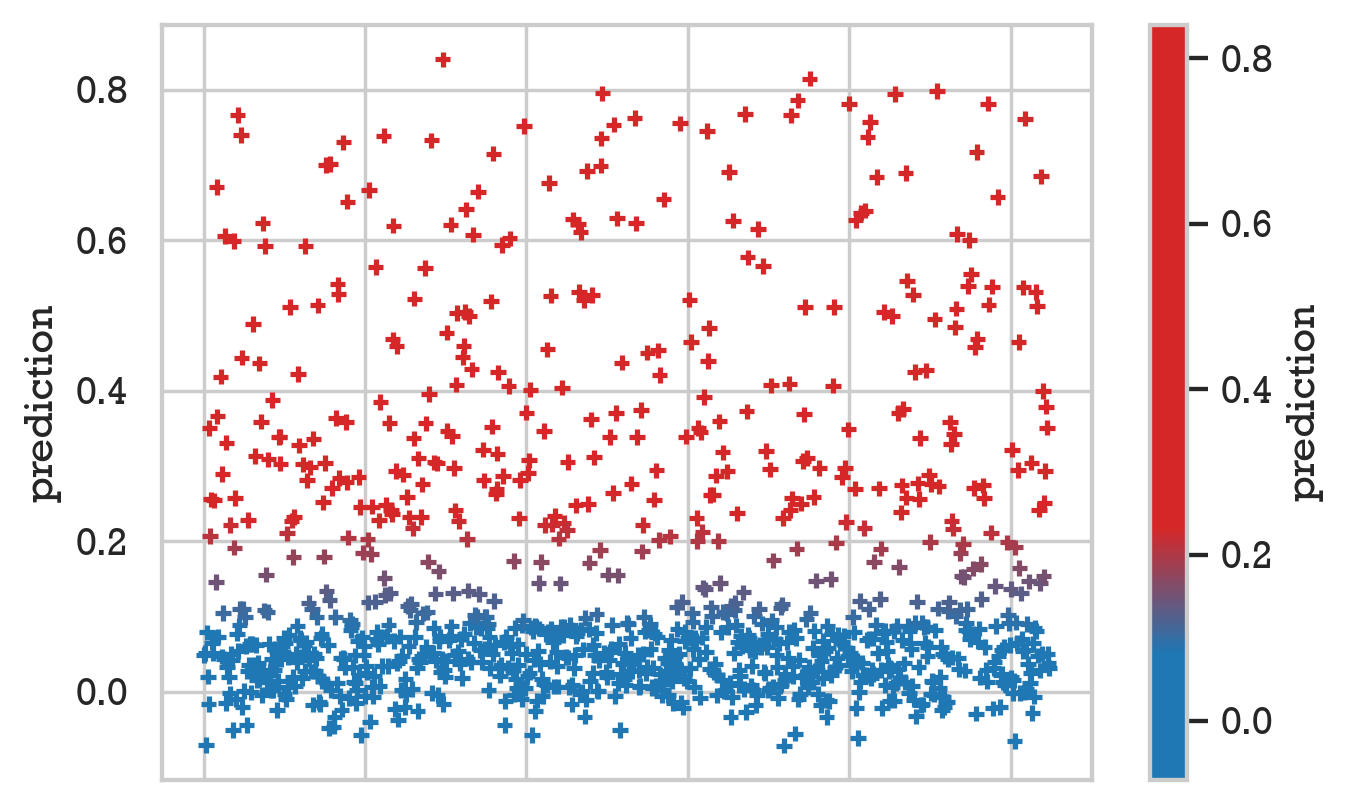

In [714]:
y_all = np.concatenate((y_train_preds, y_test_preds), axis=0)
df_y_all = pd.DataFrame(y_all, columns=['prediction'])
df_y_all['x'] = df.index

ch = sns.color_palette("tab10").as_hex()
ch1 = ch[0]
ch2 = ch[3]
pal = sns.color_palette(f'blend:{ch1},{ch1},{ch2},{ch2},{ch2},{ch2},{ch2}', as_cmap=True) 

plot = df_y_all[:1000].plot.scatter(x='x', y='prediction', marker='+', c='prediction', colormap=pal)


In [715]:
def get_model_coefficients(coefficients, variable_names, drop_variable_names=None):
    '''
    INPUT:
    coefficients - the coefficients of the linear model
    variable_names - names of variables corresponding to coefficients
    drop_variable_names - drop variables with these names (useful for removing poly offset)
    OUTPUT:
    df_c - a dataframe holding the coefficient and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    df_c = pd.DataFrame()
    df_c['variable'] =  variable_names
    df_c['c'] = lm_model.coef_
    df_c['abs(c)'] = np.abs(lm_model.coef_)
    for i in drop_variable_names:
        df_c = df_c.drop(labels=list(df_c.index[df_c['variable']==i]), axis=0)
    df_c = df_c.sort_values('abs(c)', ascending=False)
    return df_c

df_c = get_model_coefficients(lm_model.coef_, ['poly_offset'] + list(X_train.columns), drop_variable_names=['poly_offset'])

pal = sns.color_palette("pastel").as_hex()
df_c.style.bar(subset=['c'], color=[pal[3], pal[2]])


,variable,c,abs(c)
13,voted 2019,0.211792,0.211792
12,voted 2018,0.099508,0.099508
43,"voted 2016,2018,2019",0.094736,0.094736
11,voted 2017,0.089852,0.089852
8,voted 2014,0.067390,0.067390
9,voted 2015,0.065874,0.065874
10,voted 2016,0.049272,0.049272
4,voted 2010,0.042330,0.042330
7,voted 2013,0.038644,0.038644
1,age,-0.037959,0.037959


In [716]:
coef_0 = df_c['abs(c)'].iloc[0]
coef_1 = df_c['abs(c)'].iloc[1]

coef_2020 = coef_0 + (coef_0 - coef_1)

print('interpolated 2020 coefficient:',coef_2020)

interpolated 2020 coefficient: 0.32407532432739317


In [717]:
def concat_unindexed_column(df, c, name):
    '''
    INPUT: 
    df - DataFrame to add column to
    c - unindexed column
    name - name for unindexed column
    OUTPUT:
    (df) with (c) column added as (name), retaining df indexes

    Concats an unindexed column (c) to a DataFrame (df), while maintinging
    indexes in (df). The new column will use the (name) provided.
    '''

    df = df.reset_index()
    df = pd.concat([df, pd.DataFrame(c, columns=[name])], axis=1)
    df.set_index('index', inplace=True)
    return df


# add predictions to train and test sets
df_train2 = concat_unindexed_column(df_train, y_train_preds, 'pred 2020')
df_test2 = concat_unindexed_column(df_test, y_test_preds, 'pred 2020')

# concat tran and test sets
df_all = pd.concat([df_train2, df_test2])

# add original category columns
df_all = pd.concat([df_all, df_category_columns], axis=1)

# calculate the 2021 precdictions
df_all['pred 2021'] = df_all['pred 2020'] + df_all['voted 2020'] * coef_2020

# normalize the 2021 predicion column
df_all['pred 2021'] -= df_all['pred 2021'].min()
df_all['pred 2021'] /= df_all['pred 2021'].max()

df_all.head()


,age,precinct,prop value,voted 2010,voted 2011,voted 2012,voted 2013,voted 2014,voted 2015,voted 2016,...,"voted 2016,2017,2019","voted 2016,2018,2019","voted 2017,2018,2019",pred 2020,sex,party,party guess,race,ethnicity,pred 2021
1399,26,4,880.0,0,0,0,0,0,0,0,...,0,0,0,0.048471,F,U,D,WHITE,BRITISH,0.100423
5593,74,5,410.0,0,0,0,0,0,0,0,...,0,0,0,0.051261,F,D,D,WHITE,JEWISH,0.102617
6784,56,5,640.0,0,0,0,0,0,0,0,...,0,0,0,-0.070660,M,U,U,ASIAN,INDIANSUBCONTINENT,0.006758
5101,30,1,510.0,0,0,0,0,0,0,0,...,0,0,0,0.078747,M,D,D,UNKNOWN,BRITISH,0.124227
11036,62,1,430.0,0,0,0,0,0,0,0,...,0,0,0,0.019823,M,U,R,WHITE,BRITISH,0.077899


In [718]:
df_all.sort_values(['pred 2021'], ascending=False)[['pred 2021']+original_columns]

,pred 2021,age,sex,party,party guess,race,ethnicity,precinct,prop value,voted 2010,...,voted 2012,voted 2013,voted 2014,voted 2015,voted 2016,voted 2017,voted 2018,voted 2019,voted 2020,voted 2021
9599,1.000000,57,U,D,D,WHITE,BRITISH,1,480.0,0,...,0,1,1,1,1,1,1,1,1,1
2273,0.989202,41,F,D,D,WHITE,JEWISH,1,530.0,0,...,0,1,1,1,1,1,1,1,1,1
7137,0.989143,43,M,D,D,WHITE,EASTEUROPEAN,2,690.0,0,...,0,1,1,1,1,1,1,1,1,1
2041,0.987148,45,M,D,D,WHITE,BRITISH,1,870.0,0,...,0,1,1,1,1,1,1,1,1,1
4592,0.984293,56,M,D,D,WHITE,BRITISH,2,560.0,0,...,0,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9859,0.005812,55,M,U,U,ASIAN,INDIANSUBCONTINENT,5,500.0,0,...,0,0,0,0,0,0,0,0,0,0
9126,0.003483,49,F,U,U,ASIAN,INDIANSUBCONTINENT,5,540.0,0,...,0,0,0,0,0,0,0,0,0,0
9477,0.002864,50,F,U,U,ASIAN,INDIANSUBCONTINENT,5,510.0,0,...,0,0,0,0,0,0,0,0,0,0
3855,0.002285,49,F,U,U,ASIAN,INDIANSUBCONTINENT,5,410.0,0,...,0,0,0,0,0,0,0,0,0,0


In [719]:
n_records = df_all.shape[0]
n_picks = n_records // 3
n_voted_2021 = df_all.loc[(df_all['voted 2021']==1)].shape[0]

print(f'number of records: {n_records}')
print(f'number of votes: {n_voted_2021}')
print(f'number of picks: {n_picks}')

df_all['voted last 3'] = df_all['voted 2019'] & df_all['voted 2018'] & df_all['voted 2020']
df_all['voted last 2'] = df_all['voted 2018'] & df_all['voted 2020']
df_all['voted last 1'] = df_all['voted 2020']

n_pred_correct = df_all.sort_values(['pred 2021'], ascending=False)[:n_picks]['voted 2021'].sum()
n_random_correct = df_all[:n_picks]['voted 2021'].sum()

n_last_3_correct = df_all.sort_values(['voted last 3'], ascending=False)[:n_picks]['voted 2021'].sum()
n_last_2_correct = df_all.sort_values(['voted last 2'], ascending=False)[:n_picks]['voted 2021'].sum()
n_last_1_correct = df_all.sort_values(['voted last 1'], ascending=False)[:n_picks]['voted 2021'].sum()

def ratio_to_percent(numerator, denominator):
    '''
    INPUT:
    numerator - the numerator of the ratio
    denominator - the denominator of the ratio
    OUTPUT:
    ratio as percentage

    Calculates the ratio, as a percentage: numerator/denominator*100
    '''
    return numerator/denominator*100

df_results_master = pd.DataFrame({
    'Method': ['Random', 'Voted Last\n3 Years', 'Voted Last\n2 Years', 'Voted\nLast Year', 'Linear\nRegression\nModel'],
    # 'Method2': ['Random', 'Voted Last 3 Years', 'Voted Last 2 Years', 'Voted Last Year', 'Linear Regression Model'],
    '2021 Voters Reached_#': [n_random_correct, 
                            n_last_3_correct,
                            n_last_2_correct,
                            n_last_1_correct,
                            n_pred_correct,
                            ],
    '2021 Voters Reached_%': [ratio_to_percent(n_random_correct, n_voted_2021),
                ratio_to_percent(n_last_3_correct, n_voted_2021),
                ratio_to_percent(n_last_2_correct, n_voted_2021),
                ratio_to_percent(n_last_1_correct, n_voted_2021),
                ratio_to_percent(n_pred_correct, n_voted_2021),
                ],  
    'Targetting Accuracy_%': [ratio_to_percent(n_random_correct, n_picks),
                 ratio_to_percent(n_last_3_correct, n_picks),
                 ratio_to_percent(n_last_2_correct, n_picks),
                 ratio_to_percent(n_last_1_correct, n_picks),
                 ratio_to_percent(n_pred_correct, n_picks),
                 ]
})


number of records: 11278
number of votes: 2380
number of picks: 3759


In [720]:
df_results = df_results_master.copy()

df_results.columns = pd.MultiIndex.from_tuples([tuple(c.split("_")) if ('_' in c) else tuple([c,' ']) for c in df_results.columns])
df_results_styler = df_results.style.set_properties(**{'text-align': 'right'})
df_results_styler

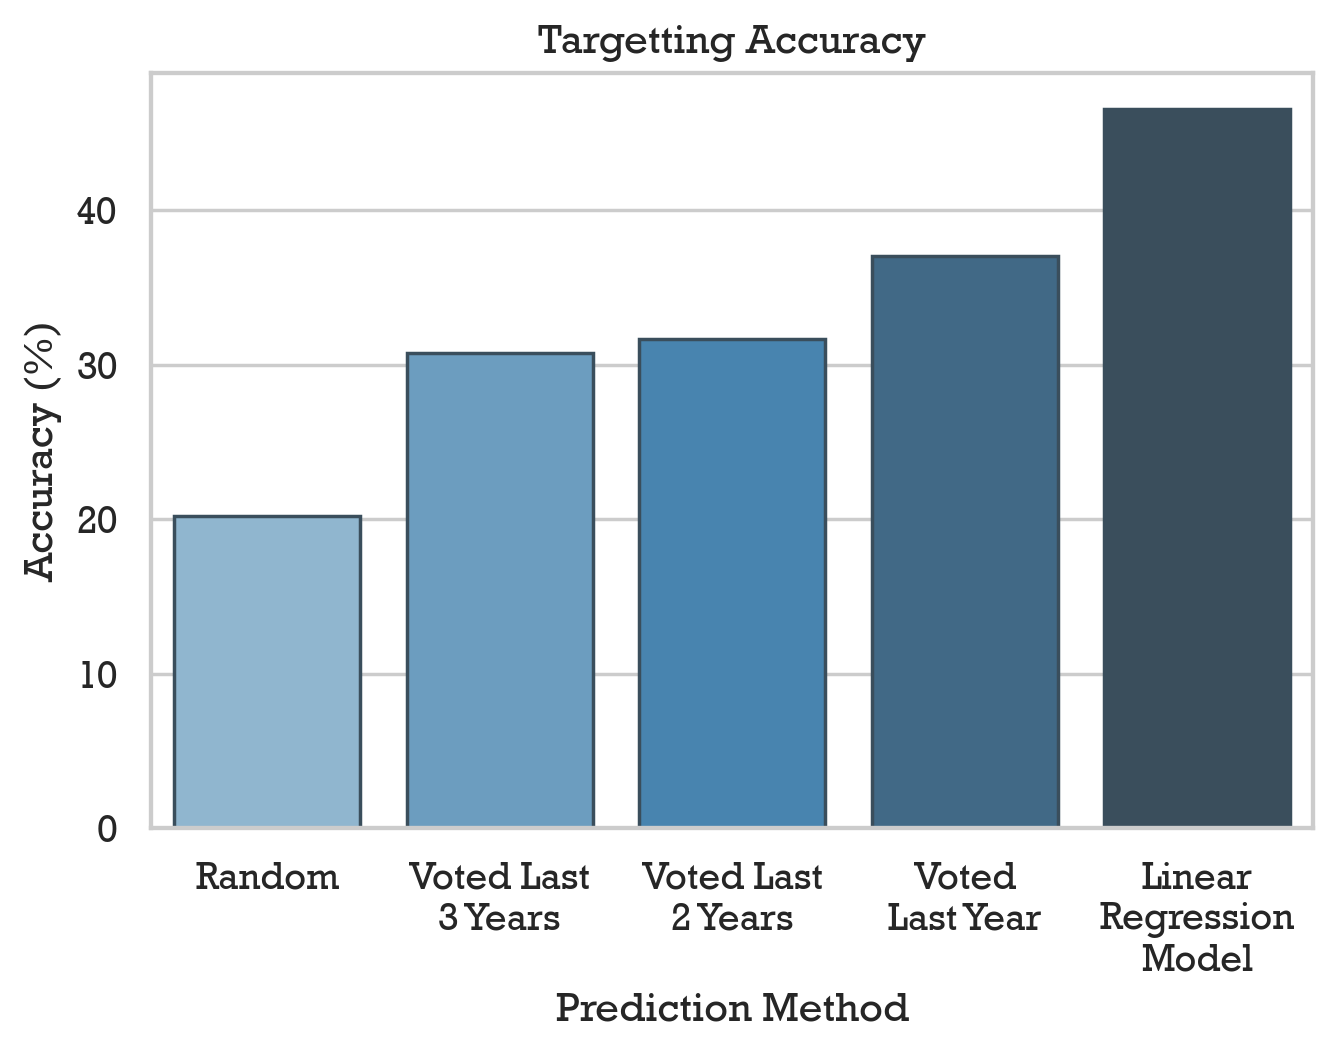

In [721]:
df_results = df_results_master.copy()

sns.set_theme()
sns.set(style='whitegrid', font="Rockwell")
palette = sns.dark_palette("#69d", reverse=True, as_cmap=True)
ax = sns.barplot(x='Method', y='Targetting Accuracy_%', data=df_results, edgecolor='#3a4e5c', palette='Blues_d')
ax.set_xlabel('Prediction Method')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Targetting Accuracy')
plt.show()


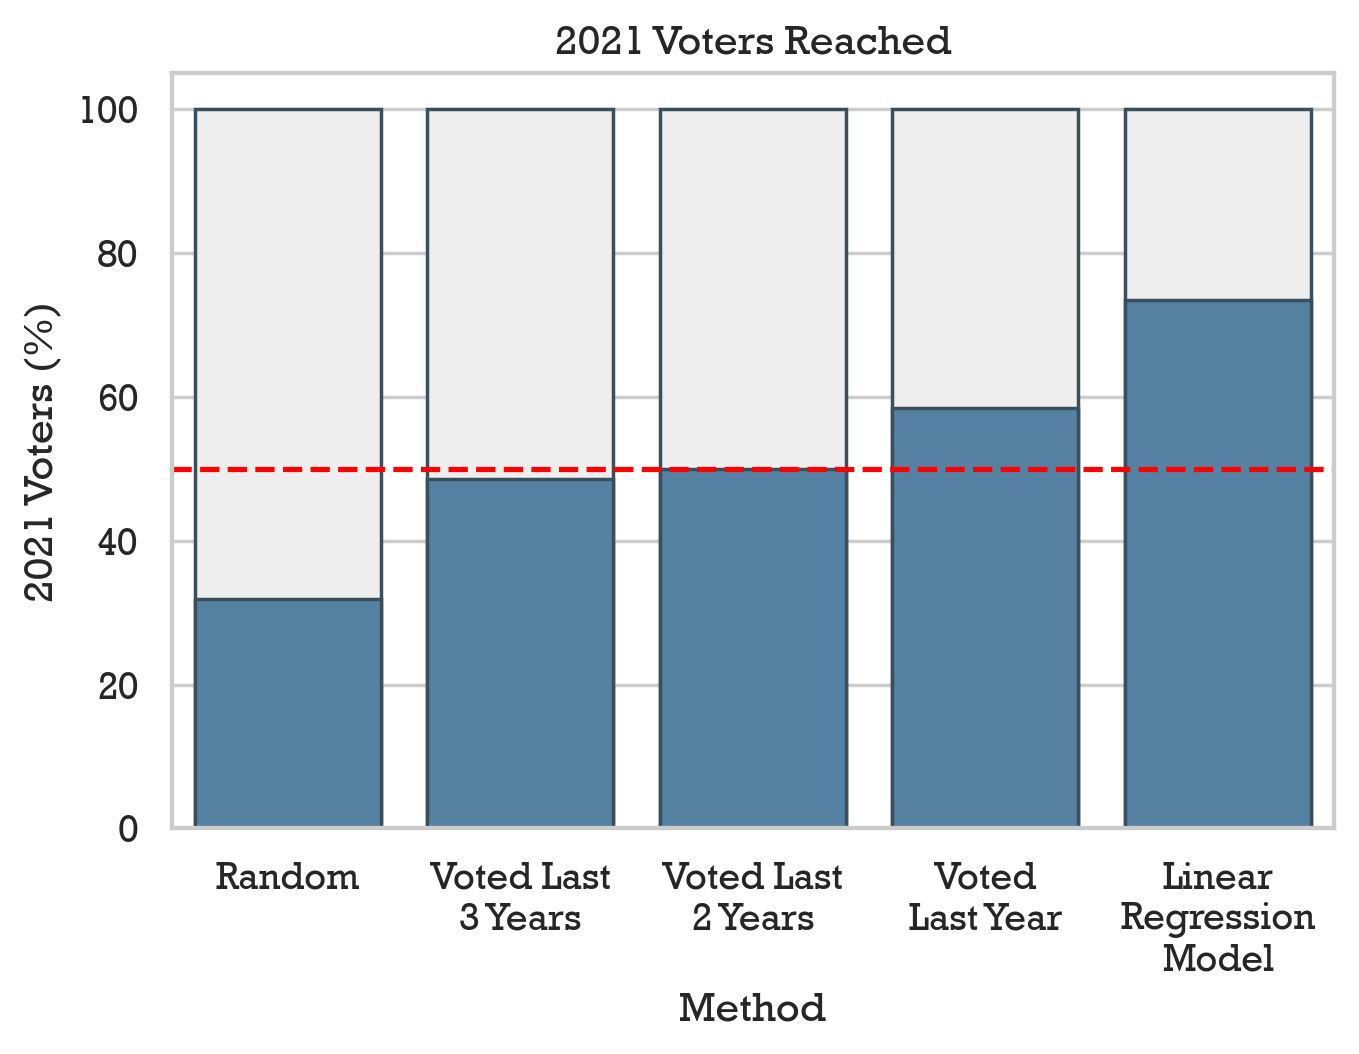

In [722]:
df_results = df_results_master.copy()

df_results['total'] = 100

sns.set_theme()
sns.set(style='whitegrid', font="Rockwell")

ax = sns.barplot(x = 'Method', y = 'total', data = df_results, color = '#eeeeee', edgecolor='#3a4e5c')
ax = sns.barplot(x = 'Method', y = '2021 Voters Reached_%', data = df_results, color = '#4884af', edgecolor='#3a4e5c')

ax.axhline(50, ls='--', color='red')

plt.xlabel('Method')
plt.ylabel('2021 Voters (%)')
plt.title('2021 Voters Reached')
plt.show()


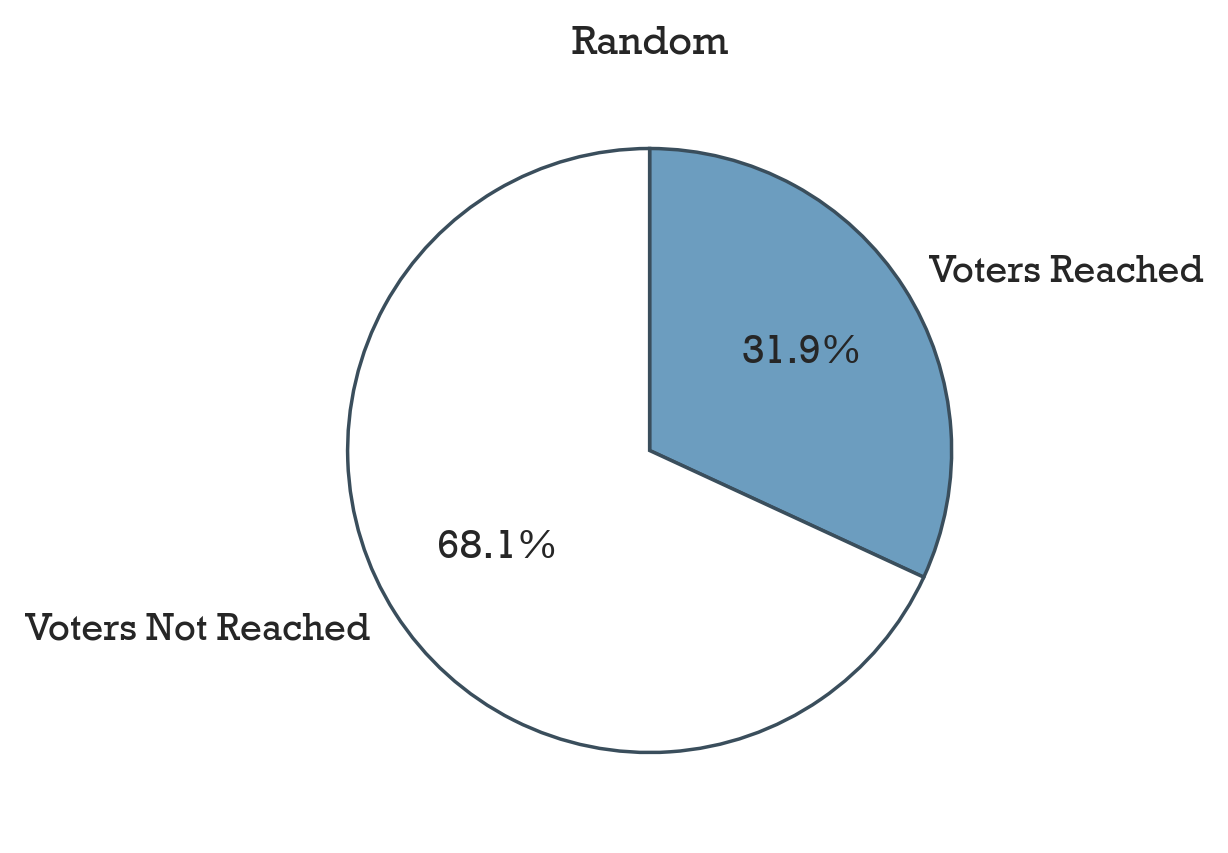

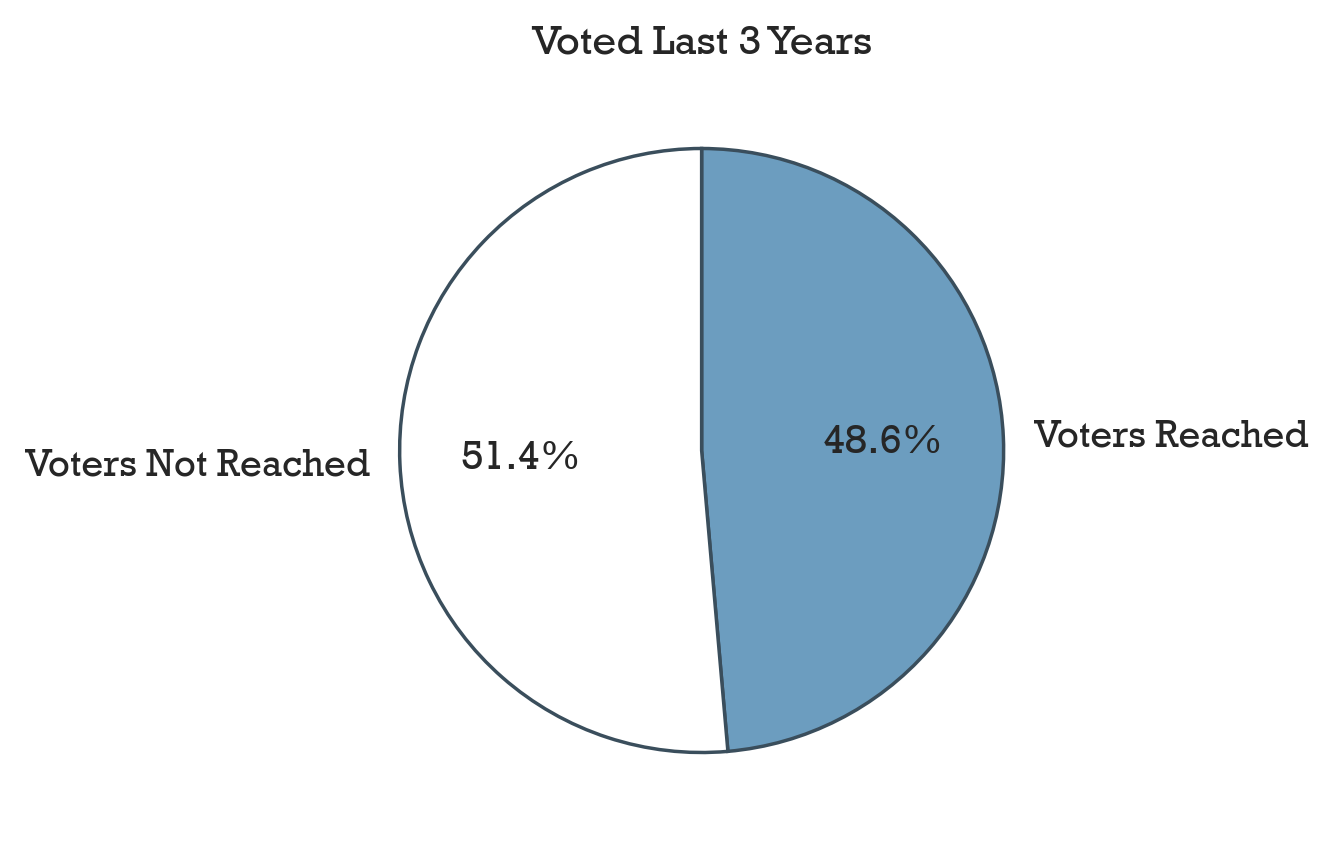

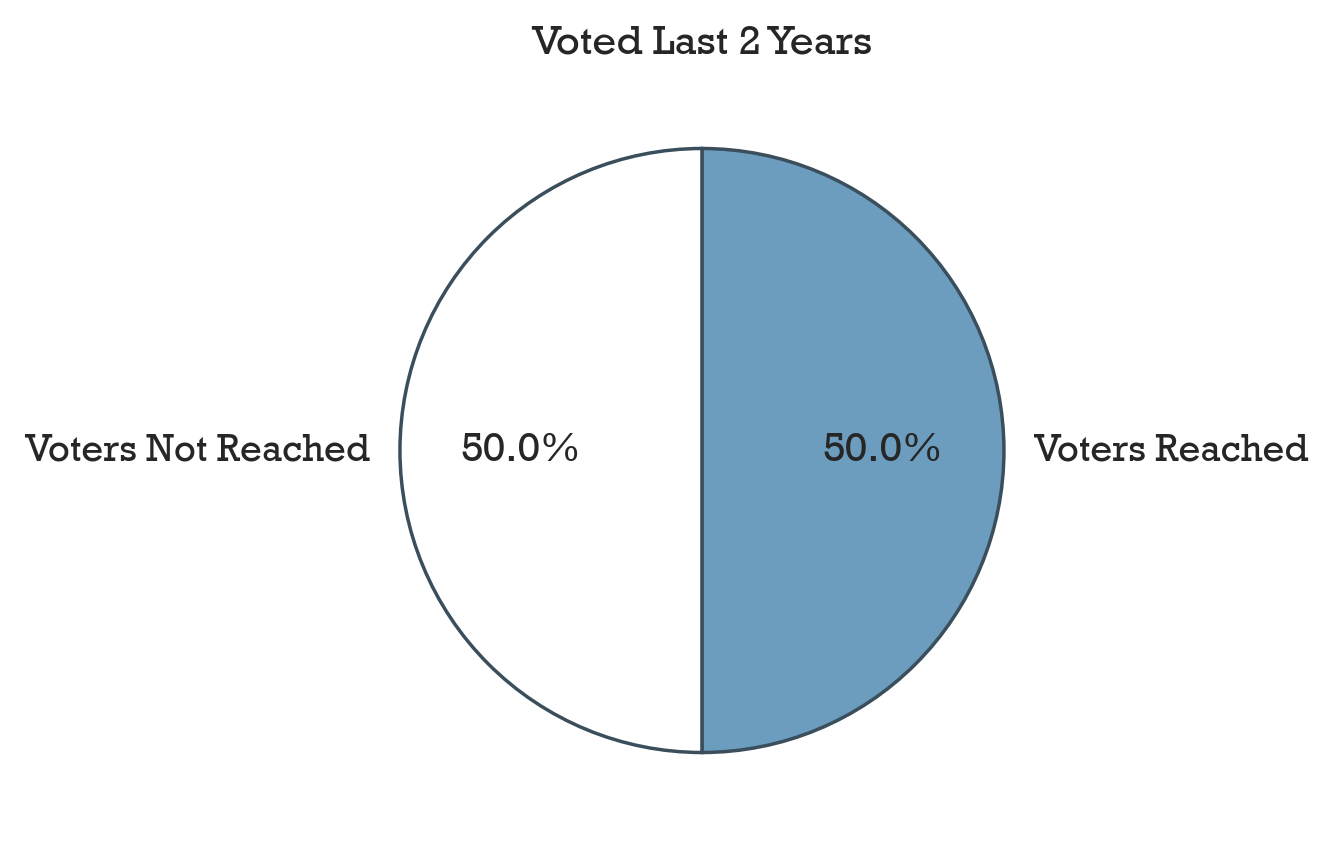

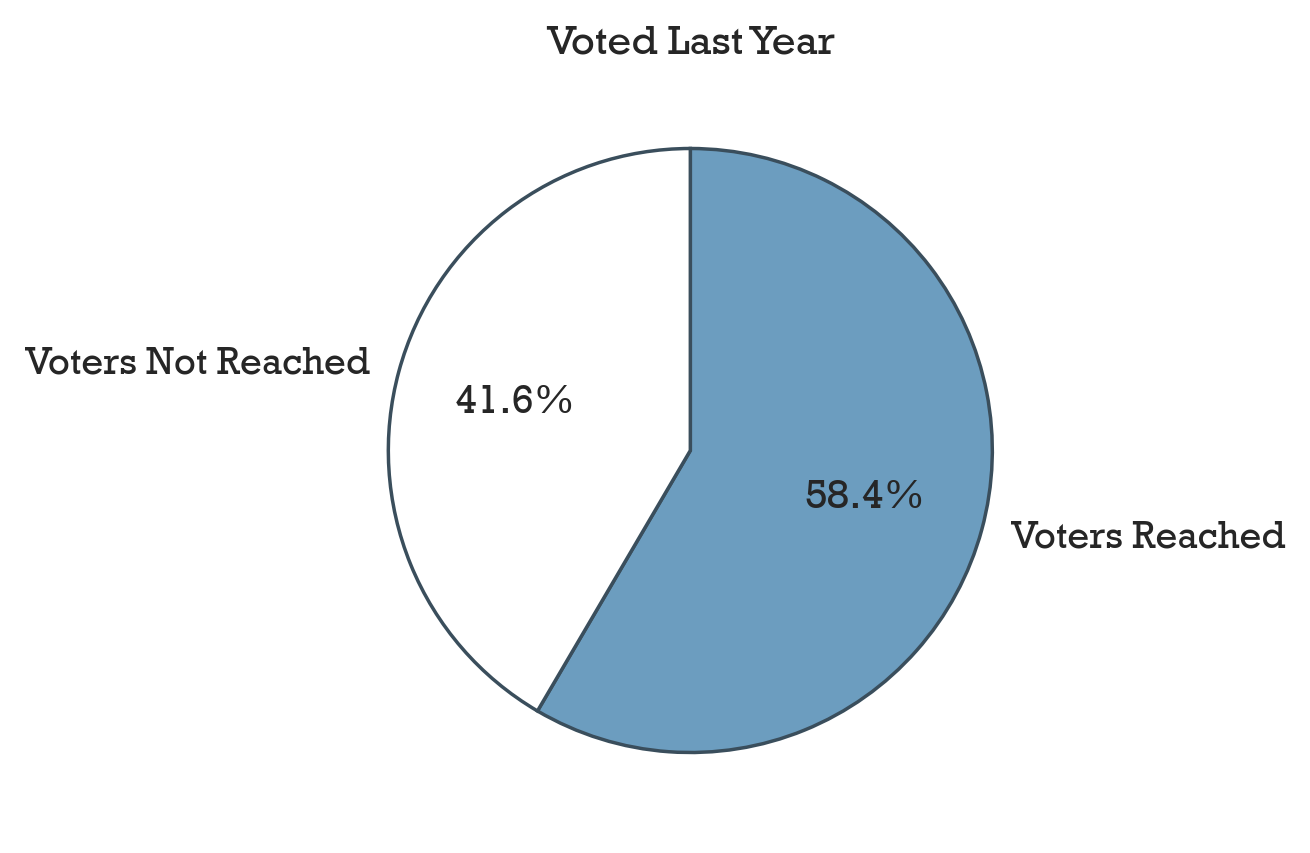

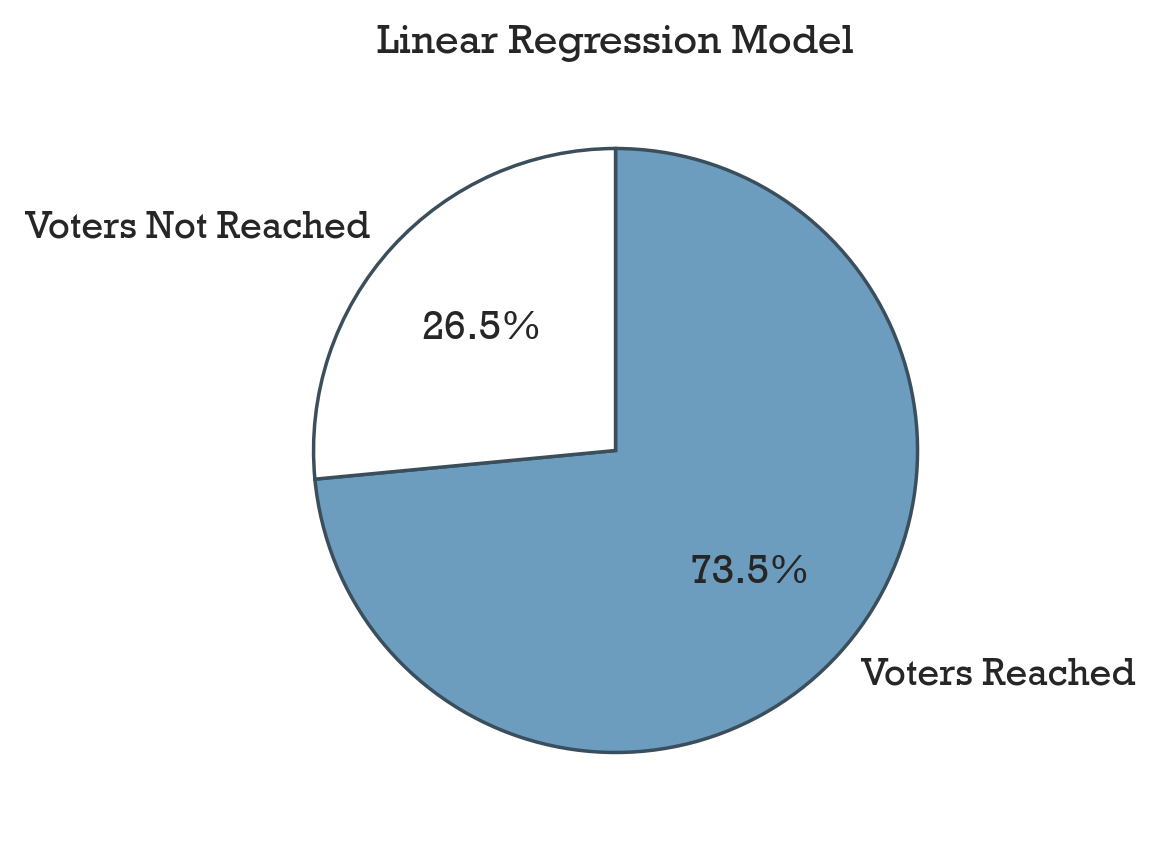

Method,Random,Voted Last 3 Years,Voted Last 2 Years,Voted Last Year,Linear Regression Model
Voters Reached,31.890756,48.613445,50.0,58.445378,73.487395
Voters Not Reached,68.109244,51.386555,50.0,41.554622,26.512605


In [723]:
df_results = df_results_master.copy()

df_results['2021 Voters not Reached_%'] = 100-df_results['2021 Voters Reached_%']

df_results['Method'] = df_results['Method'].str.replace('\n', ' ')

df_results = df_results[['Method','2021 Voters Reached_%', '2021 Voters not Reached_%']] \
                       .rename(columns={'2021 Voters not Reached_%': 'Voters Not Reached', 
                                        '2021 Voters Reached_%': 'Voters Reached'}) \
                       .set_index('Method').T

def plot_voter_piechart(df, y_column_name, title=None):
    sns.set_theme()
    sns.set(style='whitegrid', font="Rockwell")
    if title is None:
        title=y_column_name
    df.plot.pie(y=y_column_name, 
                ylabel='', 
                title=title, 
                legend=False,
                autopct = "%.1f%%",
                colors = ['#6c9dbf', 'white'],
                counterclock=False, startangle=-270,
                wedgeprops={'edgecolor':'#3a4e5c','linewidth': 1, 'antialiased': True},
                figsize=(4, 4))
    plt.show()   

plot_voter_piechart(df_results,'Random')
plot_voter_piechart(df_results,'Voted Last 3 Years')
plot_voter_piechart(df_results,'Voted Last 2 Years')
plot_voter_piechart(df_results,'Voted Last Year')
plot_voter_piechart(df_results,'Linear Regression Model')

df_results
